<center> 
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/Logo_Mondragon_Unibertsitatea.png" width="150" height="100" float ="left">
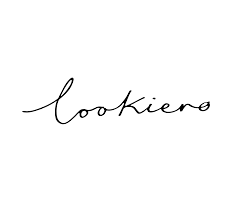    


---
<h3>Beñat Basabe, Jon Jarrín, June Pagaldai, Daniel Puente, Eneko Rentería | <font color='red'> Equipo Rojo<h3>

## Generación de grafos
Se genera el grafo que posteriormente se empleará para entrenar el modelo.

### Carga de librerias 
---

- **General**

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import pickle

def guardar_pikle(df, name):
    with open(dir_out + str(name) + '.pkl', 'wb') as fp: pickle.dump(df, fp)

def abrir_pikle(name):
    with open(dir_out + str(name) + '.pkl', 'rb') as fp: df = pickle.load(fp)
    return df

In [2]:
import warnings
warnings.filterwarnings('ignore')

- **Pyspark**

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.functions import col
from pyspark.sql.functions import when

- **Strings**

In [4]:
from collections import Counter
import re

- **Visualización**

In [5]:
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

* **Grafos**

In [6]:
import networkx as nx

- **Otros**

In [7]:
import itertools

## Funciones a utilizar
---

In [8]:
dir_in, dir_out = "../../datos/datos_originales/", "../../datos/datos_desarrollo/"

spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .getOrCreate()

- Función para **dar nombre** a la variable **family_id** mediante la variable title

In [9]:
def get_family_name(id_):
    
    filtered = product.filter(product.family_id == id_)
    string = ' '.join([x['title'] for x in filtered.select('title').collect()]).lower()
    
    return id_, Counter(string.split()).most_common(1)[0][0]

- Función para crear los **sufijos** y facilitar el *join*

In [10]:
def rename_columns(df, suffix):
    ''' Renombra las columnas de un dataframe.'''
    for names in df.schema.names: df = df.withColumnRenamed(names,names + suffix)
    return df

* Función para conseguir valores únicos de una variable en *pyspark*

In [11]:
def get_value(dffs, variable):
    return list(dffs.select(dffs[variable]).distinct().toPandas()[variable])

* Función que crea el grafo filtrando por temporada

In [21]:
def sacar_productos(e, variable, tallas = False):
    if tallas:
        list_1 = df_para_filtrar[(df_para_filtrar[variable] == e[0]) | (df_para_filtrar[variable] == 'UNQ')].index.to_list()
        list_2 = df_para_filtrar[(df_para_filtrar[variable] == e[1]) | (df_para_filtrar[variable] == 'UNQ')].index.to_list()
    else:
        list_1 = df_para_filtrar[df_para_filtrar[variable] == e[0]].index.to_list()
        list_2 = df_para_filtrar[df_para_filtrar[variable] == e[1]].index.to_list()

    return list(itertools.product(list_1, list_2))

def create_graph(seasonality, pregancy):
    
    ##############
    ##### DF #####  
    ##############

    ### Filtrar por temporada ###
    df2 = df.filter(df.season == seasonality).filter(df.pregnant == pregancy)
    
    ### Conseguir variantes de productos únicos#####
    vu_id_product = get_value(df2, 'id_product')
    
    ### Crear df para filtrar ###
    df_para_filtrar = df_indices[df_indices[0].isin(vu_id_product)]
    df_para_filtrar['family_product'] = pd.Series([e[0] for e in df_para_filtrar[0].str.split('_')])
    df_para_filtrar['level'] = df_para_filtrar.family_product.map(niveles)
    df_para_filtrar.columns = ['id_product', 'family_product', 'level']
    
    def sacar_productos(e, variable, tallas = False):
        if tallas:
            list_1 = df_para_filtrar[(df_para_filtrar[variable] == e[0]) | (df_para_filtrar[variable] == 'UNQ')].index.to_list()
            list_2 = df_para_filtrar[(df_para_filtrar[variable] == e[1]) | (df_para_filtrar[variable] == 'UNQ')].index.to_list()

            return list(itertools.product(list_1, list_2)) + list(itertools.combinations(list_1, 2)) + list(itertools.combinations(list_2, 2))
        else:
            list_1 = df_para_filtrar[df_para_filtrar[variable] == e[0]].index.to_list()
            list_2 = df_para_filtrar[df_para_filtrar[variable] == e[1]].index.to_list()

            return list(itertools.product(list_1, list_2))

    #############
    ### NODOS ###
    #############

    G = nx.Graph()
    for i, v in enumerate(df_para_filtrar.index.tolist()):
            G.add_node(v,
                      color = vu_id_product[i].split('_')[1],
                      size  = vu_id_product[i].split('_')[2],
                      level = df_para_filtrar['level'][v])
            
    ###############        
    ### ARISTAS ###
    ###############

    ### Aristas - Tallas ###
    df_para_filtrar['talla'] = df_para_filtrar['id_product'].apply(lambda x:x.split('_')[-1])
    orden_tallas = ['XXS', 'XS', 'S', 'M', 'L', 'XL', 'XXL', 'XXXL','X4XL']
                
    combinaciones_tallas_letra = []
    for i in range(1, len(orden_tallas)): combinaciones_tallas_letra += [(orden_tallas[i - 1], orden_tallas[i])]
    combinaciones_talla = list(map(sacar_productos, combinaciones_tallas_letra, ['talla'], [True]))[0]
    combinaciones_talla = list(set(combinaciones_talla))
    
    ### Aristas - Level ###
    levels = get_value(df2.filter(df2.id_product.isin(vu_id_product)), 'level')
    levels.sort()
    tods = list(itertools.combinations(levels, 2))
    tods.sort()
    tods += [('3.2', '3.2')]
    try: 
        tods.remove(('1.1', '1.2'))
    except: pass    

    combinaciones_level = list(map(sacar_productos, tods, ['level']))[0]
    
    ### Se añaden todas las aristas ###
    G.add_edges_from(list(set(combinaciones_level + combinaciones_talla)))

    ### Se empieza poniendo un peso de 0 a todas las aristas ###
    for x in G.edges(): G[x[0]][x[1]]['weight'] = 1
    return G

### Cargar datos
---

In [13]:
df = spark.read.csv(dir_out + 'lookiero_*.csv', header=True, inferSchema=True)
df_total = spark.read.csv(dir_out + 'df_total.csv', header=True, inferSchema=True)
df_indices = pd.DataFrame(get_value(df, 'id_product'))

In [14]:
embarazadas = get_value(df.filter((df.value == "pregnancy") | (df.value == "breastfeeding")), 'id_product')
df = df.withColumn("level",col("level").cast(StringType()))
df = df.withColumn("pregnant", when(df.id_product.isin(embarazadas),1).otherwise(0))

In [15]:
df.show(5)

+--------------------+------+-----+-----------+-------------+-----+------------------+--------------+----------+-------------+-----+------------+---------------+--------------------+------------------+-----+--------+
|                  id|season|stock|publishable|size_lookiero|color|        id_product|family_product|name_brand| origin_brand|value|name_feature|multiple_values|      feature_family|id_product_feature|level|pregnant|
+--------------------+------+-----+-----------+-------------+-----+------------------+--------------+----------+-------------+-----+------------+---------------+--------------------+------------------+-----+--------+
|498662e5-11e8-483...|     8|    0|       true|            M| ecru| cardigan_ecru_M_8|      cardigan|  BRAND112|NO_MAINSTREAM|   55| hip_contour|          false|c6b81db8-29ed-43d...|    hip_contour_55|  2.2|       0|
|dcda2fe4-58e3-4b2...|     8|    0|       true|            S| ecru| cardigan_ecru_S_8|      cardigan|  BRAND112|NO_MAINSTREAM|   55|

### Grafo
---

* Reglas de unión grafos

In [15]:
niveles = {'jumpsuit': '1.1', 
           'dress': '1.1',
           
           'jeans': '1.2',
           'skirt': '1.2',
           'short': '1.2',
           'pant': '1.2',
          
           'shirt': '2.1',
           'top': '2.1',
           'tshirt': '2.1',
          
           'sweater': '2.2',
           'sweatshirt': '2.2',
           'cardigan': '2.2',
          
           'trench': '3.1',
           'coat': '3.1',
           'parka': '3.1',
           'jacket': '3.1',
          
           'bag': '3.2',
           'scarf': '3.2'}

* Ponderaciones de relaciones

In [22]:
graph, combinaciones = [], list(itertools.product([7, 8, 9], [0, 1]))
for x in combinaciones:
    print(x)
    G = create_graph(x[0], x[1])
    graph.append(G)

(7, 0)
(7, 1)
(8, 0)
(8, 1)
(9, 0)
(9, 1)


In [23]:
G7, G7_pregnant, G8, G8_pregnant,G9, G9_pregnant = graph[0], graph[1], graph[2], graph[3], graph[4], graph[5]
G7.name, G8.name, G9.name, G7_pregnant.name, G8_pregnant.name, G9_pregnant.name = 'G7', 'G8', 'G9', 'G7_pregnant', 'G8_pregnant', 'G9_pregnant'

In [49]:
G7, G8, G9, G7_pregnant, G8_pregnant, G9_pregnant = map(create_graph, [7, 8, 9], [0, 1])
G7.name, G8.name, G9.name, G7_pregnant.name, G8_pregnant.name, G9_pregnant.name = 'G7', 'G8', 'G9', 'G7_pregnant', 'G8_pregnant', 'G9_pregnant'

ValueError: not enough values to unpack (expected 6, got 2)

In [95]:
F = nx.compose(G7,G7_pregnant)
F.number_of_nodes() 

2687

---

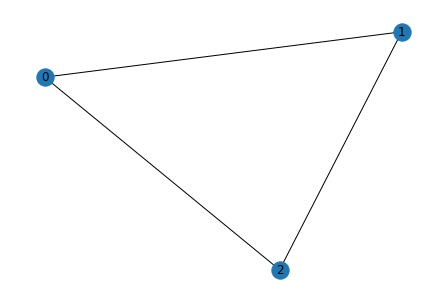

In [26]:
nx.draw(target, with_labels = True)

---